## A.load modules

In [ ]:
%pwd

In [1]:
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import marsilea as ma
import marsilea.plotter as mp

# plt.rcParams['figure.dpi'] = 150
font_dirs = ["./fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams["font.family"] = "Arial"
sns.despine(top=True, right=True)

from itertools import product
from functools import reduce
import patchworklib as pw
import seaborn.objects as so
from cycler import cycler

from mpl_toolkits.axes_grid1 import make_axes_locatable

dt_snsStyle = {**sns.axes_style('ticks'), "legend.frameon": False, "axes.spines.top":False, "axes.spines.right":False, "axes.prop_cycle":cycler(color=['grey'])}
so.Plot.config.theme.update(dt_snsStyle)

<Figure size 640x480 with 0 Axes>

<Figure size 100x100 with 0 Axes>

In [2]:
from loguru import logger
import pickle
import pysam
from concurrent.futures import ProcessPoolExecutor
from itertools import repeat
import pyBigWig
from collections import Counter
import pyranges as pr
import sys
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import pearsonr

In [3]:
sys.path.append("./termination_packages/")
import flepseq
import plot
import utilitys as utl

In [ ]:
import importlib
importlib.reload(utl)

____
## B. load reference and demo data

In [6]:
pas_info, pas_bed, single_pa_site_gene = utl.get_pas_info('../demo_data/At_reference/cbRNA.last_polya_cluster_summit.bed')

Loading successfully!


In [7]:
protein_coding_bed = '../demo_data/At_reference/Araport11_protein_coding.201606.bed'
protein_coding = pr.read_bed(protein_coding_bed, as_df=True)

protein_coding_gene = set(protein_coding['Name'].map(lambda x: x.split('.')[0]))
list(protein_coding_gene)[:3], len(list(protein_coding_gene))

(['AT5G64550', 'AT4G31050', 'AT4G28640'], 27655)

In [8]:
all_gene = set(single_pa_site_gene) & set(protein_coding_gene)
print(len(all_gene), len(single_pa_site_gene), len(protein_coding_gene))

13369 13616 27655


In [9]:
gene_model_bed = '../demo_data/At_reference/araport11.gene.bed'
gene_model = pr.read_bed(gene_model_bed, as_df=True)
gene_model = gene_model.set_index(['Name'])
gene_model.head(3)

,Chromosome,Start,End,Score,Strand
Name,,,,,
AT1G01010,1,3630,5899,.,+
AT1G01020,1,6787,9130,.,-
AT1G03987,1,11100,11372,.,+


In [10]:
polya_sites = [x for x in pas_info if x[3] in all_gene]  ### protein_coding_gene
polya_sites = np.array(polya_sites)
polya_sites[:3]
print(len(pas_info), len(polya_sites))

16616 13369


____
- sample_name sample_path_of_elongation_bam

In [11]:
_str_samples = """wt ../demo_data/wt_seedling_elongation.bam
fy ../demo_data/fy_elongation.bam"""

____
- get data_path dictionary of elongation bam files

In [12]:
data_path = {}
for x in _str_samples.split("\n"):
    tl = x.split(" ")
    data_path[tl[0]] = tl[1]
    if not os.path.exists(tl[1]):  
        print(f"Please check input file: {tl[1]}!")
data_path

Please check input file: ../demo_data/wt_seedling_elongation.bam!


{'wt': '../demo_data/wt_seedling_elongation.bam',
 'fy': '../demo_data/fy_elongation.bam'}

____
## C. Calculate the termination windiw of each sample

- run calculate the `termination window` of demo samples with multiple threads (12)

In [14]:
ls_order = list(data_path.keys())

for sample in tqdm(data_path.keys(), total = len(data_path.keys())):
    sample_data = data_path[sample]
    variable_used = sample
    
    code_flepseq_termination_window_turbo = variable_used + " = " + \
    "flepseq.termination_window_turbo(sample_data, pas_info, method = \"raw\", threads=12)"

    exec(code_flepseq_termination_window_turbo)
    print(f"{sample_data} loaded successfully!")

 50%|█████     | 1/2 [00:33<00:33, 33.46s/it]

../demo_data/wt_seedling_elongation.bam loaded successfully!


100%|██████████| 2/2 [00:55<00:00, 27.85s/it]

../demo_data/fy_elongation.bam loaded successfully!


____
- Store the dataframe together

In [15]:
variable_used = "_lsDf_tem"
code_create_tem = variable_used + " = " + \
    "[" + ",".join([sample for sample in ls_order]) + "]"
print(f"Running code: {code_create_tem}")
exec(code_create_tem)

Running code: _lsDf_tem = [wt,fy]


____
- Save the termination windows result to pickle
    - enables the recall of data for reuse in subsequent analyses

In [16]:
code_flepseq_termination_window_turbo

'fy = flepseq.termination_window_turbo(sample_data, pas_info, method = "raw", threads=12)'

In [17]:
len(wt), len(fy)

(8612, 6627)

In [18]:
dic_flepseq_TWs_distribution = {"Description":{"Date":"2024.1.1", \
                                        "Samples": _str_samples, \
                                        "Samples_num":2, \
                                        "Core Code": "sample = flepseq.termination_window_turbo(sample, pas_info, method = \"raw\", threads=12)", \
                                      }}
dic_flepseq_TWs_distribution["Data"] = {x:y for x, y in zip(ls_order, _lsDf_tem)}

with open("demo.termination_window_data.2_samples.24_1_1.pickle", 'wb') as f:
    pickle.dump(dic_flepseq_TWs_distribution, f)

____
- load data from pickle
    - Storing dataframe in a variable `with the same name`

In [19]:
dic_flepseq_TWs_distribution = utl.lp("demo.termination_window_data.2_samples.24_1_1.pickle")

for k in dic_flepseq_TWs_distribution["Data"].keys():
    code = k + " = " + \
           "dic_flepseq_TWs_distribution[\"Data\"][\""+ k +"\"]"
    exec(code)
    print(f"Running {code}")

Running wt = dic_flepseq_TWs_distribution["Data"]["wt"]
Running fy = dic_flepseq_TWs_distribution["Data"]["fy"]


____
- Preview data of wt_seedling and *fy*
    - `data` column represents the readthrough distance of each gene

In [20]:
wt = utl.termination_window(wt, all_gene)
fy = utl.termination_window(fy, all_gene)
len(wt), len(fy)

(7065, 5397)

In [21]:
wt.head(3)

,gene_id,data
0,AT1G01020,"[838, 704, 624, 621, 585, 508, 495, 440, 422, ..."
1,AT1G01050,"[291, 214, 204, 187, 183, 178, 173, 172, 165, ..."
3,AT1G01100,"[604, 453, 409, 397, 396, 394, 394, 379, 359, ..."


In [22]:
fy.head(3)

,gene_id,data
0,AT1G01020,"[777, 655, 548, 519, 519, 485, 467, 422, 422, ..."
2,AT1G01090,"[268, 238, 223, 223, 182, 121, 121, 112, 100, ..."
3,AT1G01100,"[581, 483, 483, 478, 430, 413, 392, 361, 354, ..."


____
## D. Draw xyplot 
- X-axis and Y-axis represents the two sample
- Each point represents a gene

### Load functions of xyplot

In [23]:
import jpy_tools.overlapTools
importlib.reload(jpy_tools.overlapTools)
from jpy_tools.overlapTools import GeneOverlapBase
import scipy
# from scipy import Literal, Union, List, Dict, Optional

In [24]:
from jpy_tools.otherTools import F
from jpy_tools.soExt import Axhline, Axvline, Axline, KdeDensityColor

from scipy.stats import mannwhitneyu
from scipy.interpolate import interpn
from scipy.stats import gaussian_kde
import math

In [25]:
import sys
sys.path.append("./termination_packages/")
import tw_xyplot as xypt

____
- Create compare termination instance object `ct_ori`

In [26]:
ct_ori = xypt.CompareTermination()

____
- Compare wt with *fy*

ct_ori.addMockData('Mock', Mock) # add control first

ct_ori.addComparedData('Mutant', Mutant, 'Mock') # determine which sample to use as control


In [27]:
ct_ori.addMockData('wt', wt)
ct_ori.addComparedData('fy', fy, 'wt')

____
- creat the list for comparing the TW

In [28]:
compare_list_com = ['fy'] 

In [29]:
ct_ori.dt_compareMockRelation.keys()

for name, path in data_path.items():
    ct_ori.addElongationBam(name, path)
    
ct_ori.getAllGeneCoverage(list(ct_ori.dt_compareMockRelation.keys()), polya_sites)

df_res, p = ct_ori.getCoverageForMetaplot(compare_list_com, dt_genes={'All':None} , \
                                      scaleMethod='pas')

ct_ori.getPvalueUseUtest()
ct_ori.getTerminationLengthDifferenceAndFc()

100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


____
- Cut P-value 0.001

In [30]:
ct001 = ct_ori
ct001.setCutoff(fc=0, pvalue=0.001)

____
- summary the sample by datafrmae

In [31]:
_df = pd.concat(
    [ct001.dtPvalueInfo[x].value_counts("significant").rename(x)
    for x in compare_list_com],
    axis=1).T.fillna(0).astype(int).assign(
        x=100, 
        y=800, 
        text = lambda _: _.apply(lambda _: f"Up = {_.Up}\nDown = {_.Down}", axis=1)).reset_index()

____
- draw xyplot
    - y-axis is wt_seedling termination window
    - x-axis is *fy* termination window

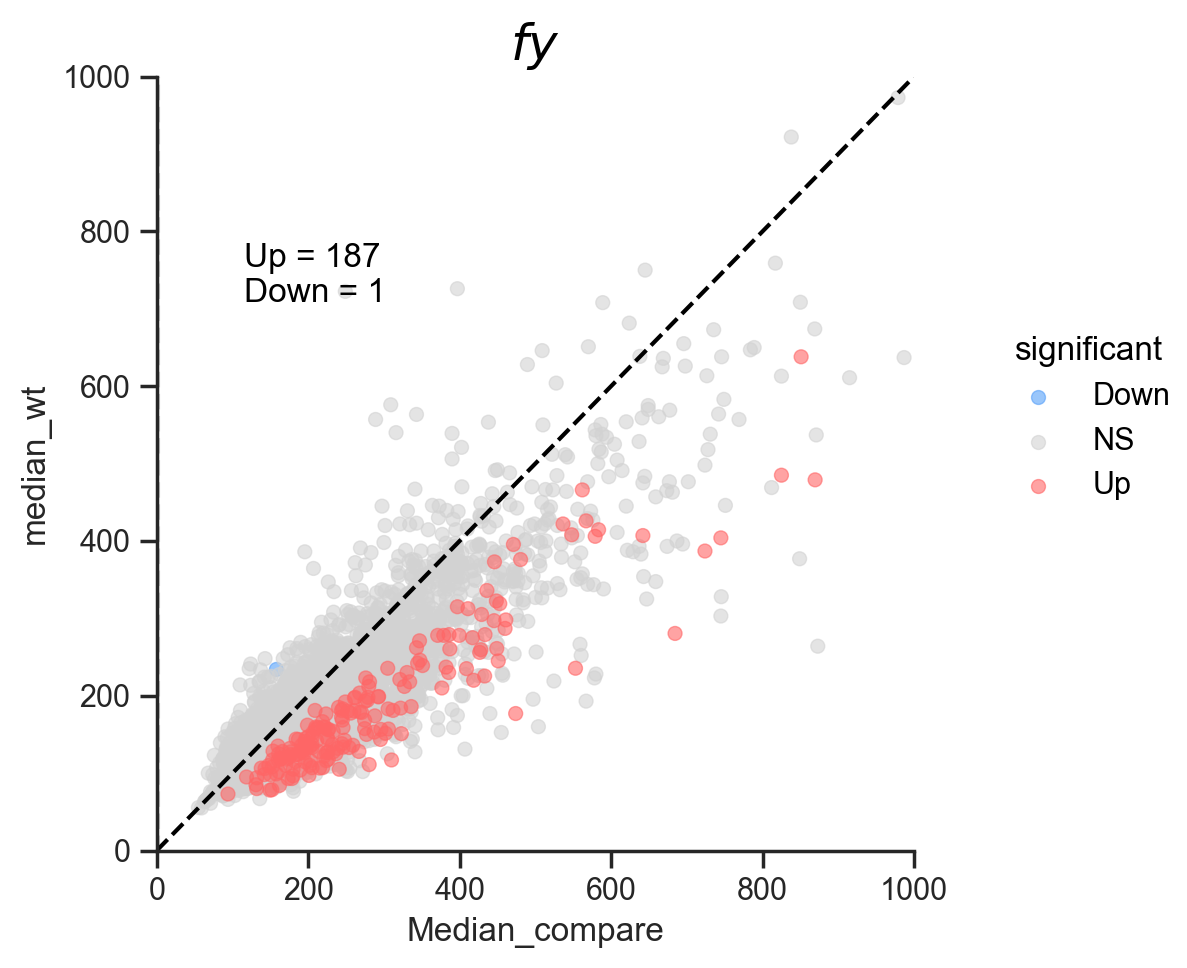

In [32]:
p = (
    ct001.scatterPlot(
        ct001.dtPvalueInfo.keys(), "median_compare", "median_wt", color="significant"
    ).scale(color={"NS": "#d2d2d2", "Up": '#FF6666' , 'Down': '#56A0F9'})\
    .limit(x=(0, 1000), y=(0, 1000))
    .add(so.Text(color='black', halign='left', valign='top'), x='x', y='y', col='index', text='text', data=_df)
    .add(
        Axline(intercept=0, slope=1, color="black", linestyle="--"),
        legend=False,
        x=None,
        y=None,
        color=None,
        data={},
    )
    .layout(size=(5, 5))
    .theme({"axes.titlesize": 18})
    .label(title=lambda _: f"${_}$" if not "wt" in _.lower() else _)
    .facet(col="name", wrap=1, order= compare_list_com) ### ct001.dtPvalueInfo.keys()
)
fig = p.plot()._figure
for ax in fig.axes:
    ax.xaxis.set_tick_params(labelbottom=True)

fig

____
- If the above script reports an error or fails to draw, use the following script
    - If you still get an error, please copy the function `merge_data_draw_xy` into jupyter and run it directly.

(        gene_id  data_x  data_y  p_values  color
 0     AT1G01020   346.0   202.0  0.011367    0.0
 1     AT1G01100   192.0   148.0  0.125621    0.0
 2     AT1G01120   140.0   145.0  0.420147    0.0
 3     AT1G01160   113.5   158.0  0.112902    0.0
 4     AT1G01170   121.0   122.0  0.340205    0.0
 ...         ...     ...     ...       ...    ...
 5007  AT5G67500   250.0   207.5  0.049337    0.0
 5008  AT5G67510   219.5   266.5  0.327101    0.0
 5009  AT5G67560   164.0   119.0  0.000459    1.0
 5010  AT5G67590   153.0   155.0  0.219119    0.0
 5011  AT5G67600   331.0   194.0  0.009905    0.0
 
 [5012 rows x 5 columns],
 <Axes: >)

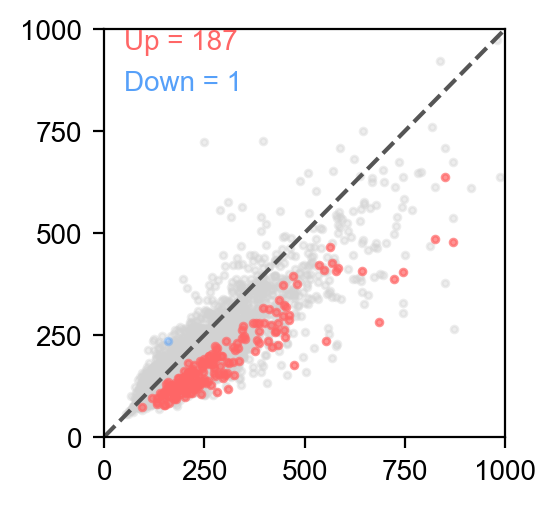

In [33]:
plt.figure(figsize=(15, 9))
plt.subplot(3,5,1)

xypt.merge_data_draw_xy(
        fy,
        wt,
    data1_label='',
    data1_font_style='italic',
)

____
## E. Calculate the cleavage ratios of each sample

- run progress: calculate the `cleavage ratios` of demo samples with multiple threads (12)

In [34]:
data_path

{'wt': '../demo_data/wt_seedling_elongation.bam',
 'fy': '../demo_data/fy_elongation.bam'}

In [35]:
ls_order = list(data_path.keys())

for sample in tqdm(data_path.keys(), total = len(data_path.keys())):
    sample_data = data_path[sample]
    variable_used = sample + "_ratio"
    
    code_count_rna_intermediates_turbo = variable_used + " = " + \
    "flepseq.count_rna_intermediates_turbo(sample_data, pas_info, threads=12)"

    exec(code_count_rna_intermediates_turbo)
    print(f"{sample_data} loaded successfully!")

 50%|█████     | 1/2 [00:33<00:33, 34.00s/it]

../demo_data/wt_seedling_elongation.bam loaded successfully!


100%|██████████| 2/2 [00:59<00:00, 29.69s/it]

../demo_data/fy_elongation.bam loaded successfully!


In [36]:
code_count_rna_intermediates_turbo

'fy_ratio = flepseq.count_rna_intermediates_turbo(sample_data, pas_info, threads=12)'

____
- Preview data of wt_seedling and *fy*
    - `readthrough` column represents the readthrough transcript of each gene
    - `5'cleavage ` column represents the 5'cleavage products of each gene
    - `3'cleavage ` column represents the 3'cleavage products of each gene
- Here's the schematic, from the article


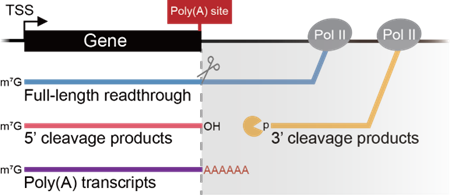

In [37]:
len(wt_ratio),len(fy_ratio)

(8335, 6391)

In [38]:
wt_ratio.head(3)

,gene_id,readthrough,5_cleavage,3_cleavage
0,AT1G01020,52,12,11
1,AT1G01050,23,8,0
2,AT1G01080,31,9,3


In [39]:
fy_ratio.head(3)

,gene_id,readthrough,5_cleavage,3_cleavage
0,AT1G01020,23,7,2
1,AT1G01080,26,14,1
2,AT1G01100,79,35,8


In [40]:
wt_ratio = utl.cleaved_ratio(wt_ratio, all_gene)
fy_ratio = utl.cleaved_ratio(fy_ratio, all_gene)

In [41]:
variable_used = "_lsDf_cl"
code_create_tem = variable_used + " = " + \
    "[" + ",".join([sample + "_ratio" for sample in ls_order]) + "]"
print(f"Running code: {code_create_tem}")
exec(code_create_tem)

Running code: _lsDf_cl = [wt_ratio,fy_ratio]


In [42]:
len(wt_ratio), len(fy_ratio)

(6839, 5209)

____
- Store to pickle

In [43]:
dic_flepseq_CIs_distribution = {"Description":{"Date":"2024.1.1", \
                                        "Samples": _str_samples, \
                                        "Samples_num":2, \
                                        "Core Code": "sample = flepseq.count_rna_intermediates_turbo(sample_data, pas_info, threads=12)", \
                                      }}
dic_flepseq_CIs_distribution["Data"] = {x:y for x, y in zip(ls_order, _lsDf_cl)}

with open("demo.cleavage_index_data.2_samples.24_1_1.pickle", 'wb') as f:
    pickle.dump(dic_flepseq_CIs_distribution, f)

____
- Obtain readthrough distance again and calculate the TW

In [44]:
dic_flepseq_TWs_distribution = utl.lp("demo.termination_window_data.2_samples.24_1_1.pickle")

for k in dic_flepseq_TWs_distribution["Data"].keys():
    code = k + " = " + \
           "dic_flepseq_TWs_distribution[\"Data\"][\""+ k +"\"]"
    exec(code)
    print(f"Running {code}")
    
variable_used = "_lsDf_tem"
code_create_tem = variable_used + " = " + \
    "[" + ",".join([sample for sample in ls_order]) + "]"
print(f"Running code: {code_create_tem}")
exec(code_create_tem)

Running wt = dic_flepseq_TWs_distribution["Data"]["wt"]
Running fy = dic_flepseq_TWs_distribution["Data"]["fy"]
Running code: _lsDf_tem = [wt,fy]


In [45]:
for _x in _lsDf_tem:
    _x['median'] = _x['data'].map(np.median)
    _x.set_index(["gene_id"], inplace=True)

In [46]:
len(wt), len(fy)

(8612, 6627)

____
- draw Cleavege activaty by xyplot
    - X-axis is fy
    - Y-axis is wt

In [47]:
WT_cleavage, WT_result = utl.cleavage_and_tw(_lsDf_cl[::-1], _lsDf_tem[::-1], 
                                             all_gene)

<Axes: xlabel='fy', ylabel='WT'>

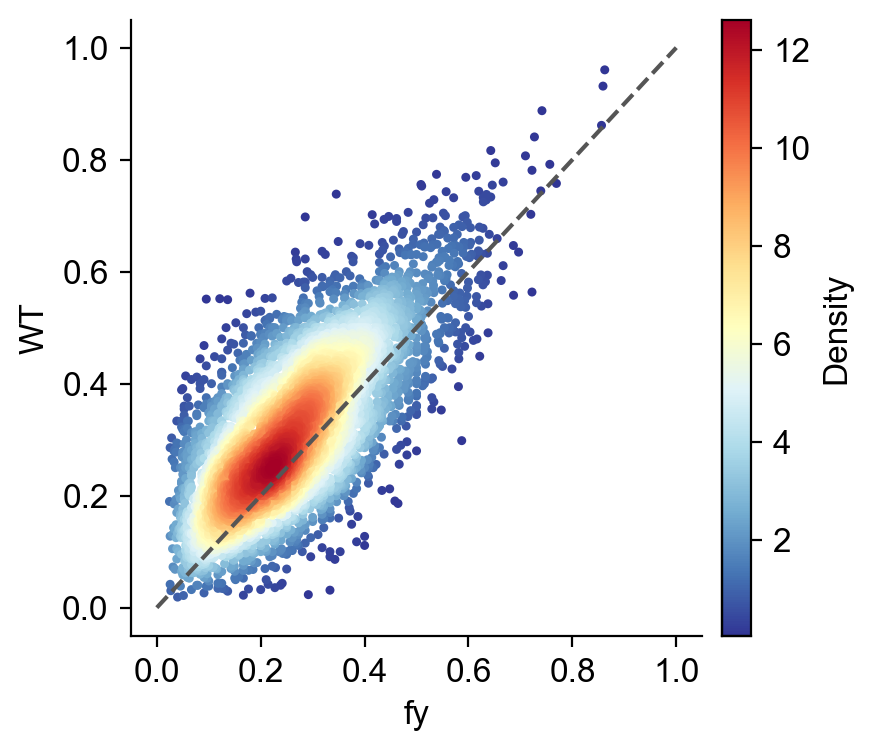

In [49]:
xypt.twoD_density_xyplot(data = WT_cleavage,
                         control_name = "WT",
                         mutant_name = "fy")

____
- relationship between the difference in termination window size (x-axis) and the log2 fold change of cleavage index (y-axis) between the wt seedling and *fy*

<Axes: title={'center': 'fy vs WT'}, xlabel='change in termination window', ylabel='change in cleavage ratio'>

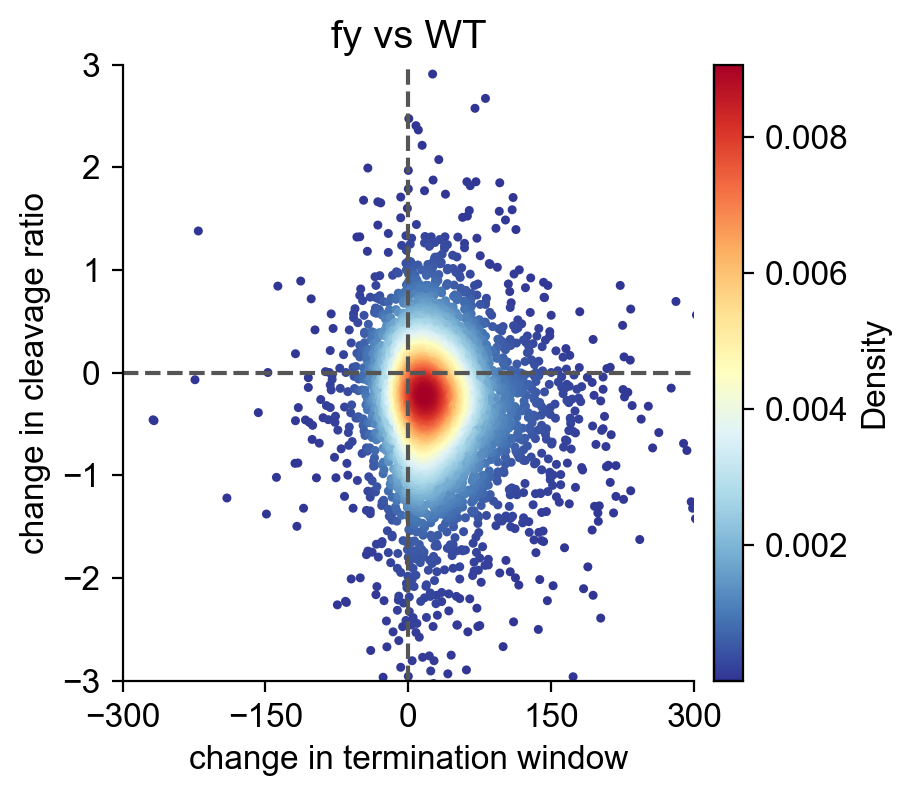

In [50]:
xypt.twoD_density_xyplot_v2(data = WT_result,
                            control_name = "WT",
                            mutant_name = "fy")

## F. Draw metaplot

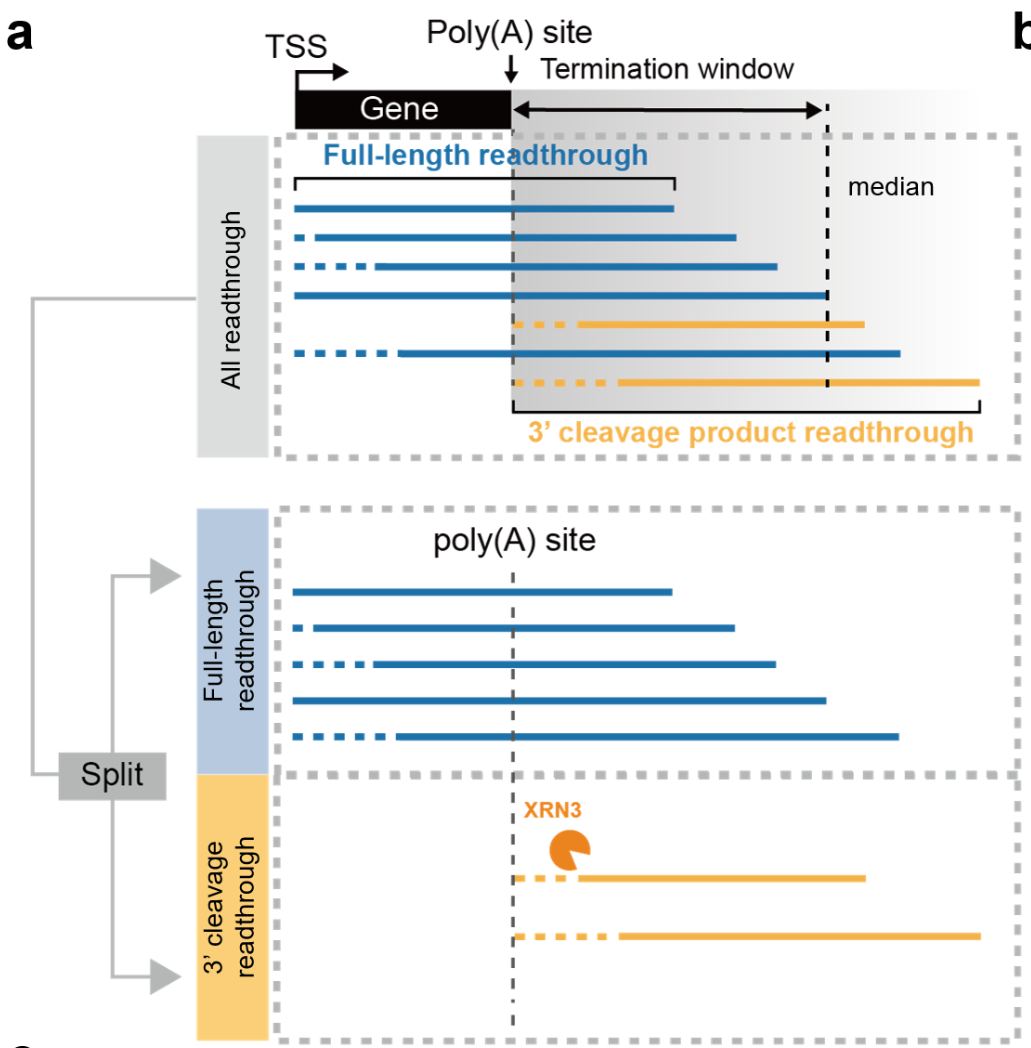

In [51]:
import metaplot

In [52]:
%pwd

'/data/Zhaijx/lijz/Termination_project/git_fold/termination_git_upload/Zhai_lab/scripts'

In [53]:
output_res = pd.read_csv('/public/home/mowp/test/output_res.csv')
all_gene = set(output_res['gene_id'])
len(all_gene)

9830

In [54]:
ls_order = ['wt' , 'fy']

In [56]:
last_pa = metaplot.last_pa_func('../demo_data/At_reference/cbRNA.last_polya_cluster_summit.bed')
gene_model = metaplot.gene_model_func('../demo_data/At_reference/araport11.gene.bed')
distance_to_downstream = metaplot.downstream_df("../demo_data/araport11.distance_to_downstream_gene.bed")

____
- draw `All readthrough` parts

In [56]:
ls_order

['wt', 'fy']

In [59]:
for sample in ls_order:
    sample_data = "../demo_data/seperate_intermediates/" + sample + "/readthrough_three_merge.cl.bam"
    variable_used = sample

    code_3_5_end_pos_turbo = variable_used + "_rtcl = " + \
    "metaplot.get_three_end_pos_turbo(sample_data, all_gene, last_pa, gene_model, distance_to_downstream, before=200, after=1000)"

    exec(code_3_5_end_pos_turbo)
    print(sample_data + " loaded successfully!")

../demo_data/seperate_intermediates/wt/readthrough_three_merge.cl.bam loaded successfully!
../demo_data/seperate_intermediates/fy/readthrough_three_merge.cl.bam loaded successfully!


In [60]:
# dic_all_readthrough = {"Description":{"Date":"2024.1.1", \
#                                       "Samples": "wt\tfy", \
#                                       "Samples_num":2, \
#                                       "Core Code": code_3_5_end_pos_turbo, \
#                                       }}
# dic_all_readthrough["Data"] = {"wt":wt_rtcl, "fy":fy_rtcl}

# with open("demo.all_readthrough.24_1_1.pickle", 'wb') as f:
#     pickle.dump(dic_all_readthrough, f)

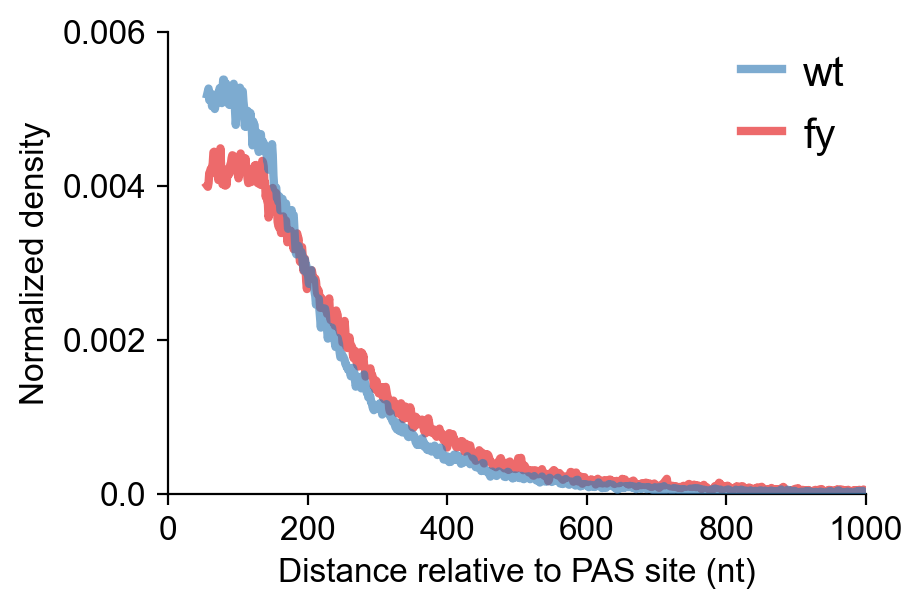

In [61]:
sample1 = ls_order[0]
sample2 = ls_order[1]
gcf = metaplot.draw_comp_PAS_rtcl(eval(sample1 + "_rtcl")[0], 
                                  eval(sample1 + "_rtcl")[1], 
                                  eval(sample2 + "_rtcl")[0], 
                                  eval(sample2 + "_rtcl")[1], 
                                  sample1, sample2)

____
- draw `full-length readthrough` parts

In [ ]:
for sample in ls_order:
    sample_data = "../demo_data/seperate_intermediates/" + sample + "/readthrough_cl.bam"
    variable_used = sample

    code_3_5_end_pos_turbo = variable_used + "_rt = " + \
    "metaplot.get_three_end_pos_turbo(sample_data, all_gene, last_pa, gene_model, distance_to_downstream, before=200, after=1000)"

    exec(code_3_5_end_pos_turbo)
    print(sample_data + " loaded successfully!")

In [63]:
# dic_full_len_readthrough = {"Description":{"Date":"2024.1.1", \
#                                       "Samples": "wt\tfy", \
#                                       "Samples_num":2, \
#                                       "Core Code": code_3_5_end_pos_turbo, \
#                                       }}
# dic_full_len_readthrough["Data"] = {"wt":wt_rt, "fy":fy_rt}

# with open("demo.fl_readthrough.24_1_1.pickle", 'wb') as f:
#     pickle.dump(dic_full_len_readthrough, f)

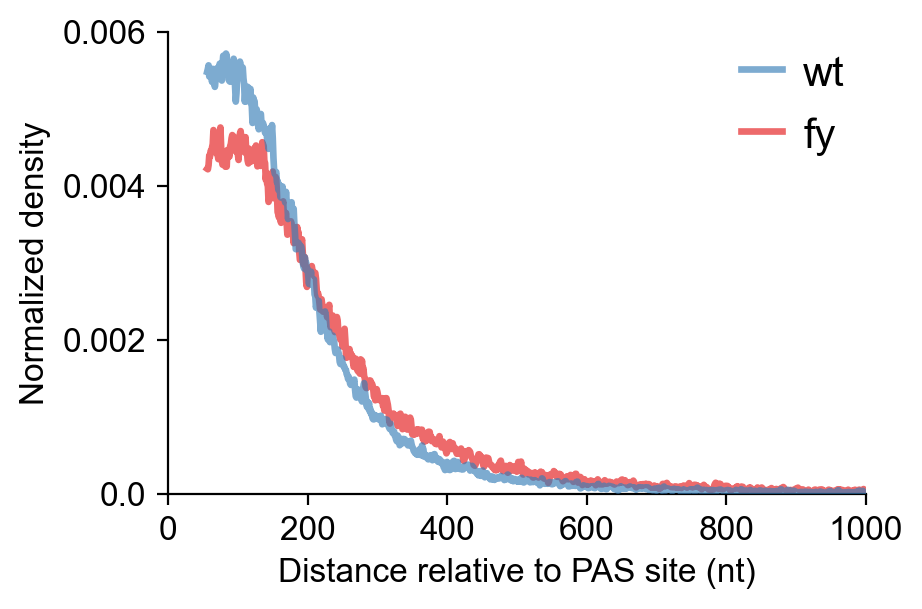

In [64]:
sample1 = ls_order[0]
sample2 = ls_order[1]
gcf = metaplot.draw_comp_PAS_rt(eval(sample1 + "_rt")[0], 
                                eval(sample1 + "_rt")[1], 
                                eval(sample2 + "_rt")[0], 
                                eval(sample2 + "_rt")[1], 
                                sample1, sample2)

_____
- draw `3'products transcript` part

In [65]:
for sample in ls_order:
    sample_data = "../demo_data/seperate_intermediates/" + sample + "/three_cl.bam"
    variable_used = sample

    code_3_5_end_pos_turbo = variable_used + "_cl = " + \
    "metaplot.get_three_end_pos_turbo(sample_data, all_gene, last_pa, gene_model, distance_to_downstream, before=200, after=1000)"

    exec(code_3_5_end_pos_turbo)
    print(sample_data + " loaded successfully!")

../demo_data/seperate_intermediates/wt/three_cl.bam loaded successfully!
../demo_data/seperate_intermediates/fy/three_cl.bam loaded successfully!


In [66]:
# dic_full_len_readthrough = {"Description":{"Date":"2024.1.1", \
#                                       "Samples": "wt\tfy", \
#                                       "Samples_num":2, \
#                                       "Core Code": code_3_5_end_pos_turbo, \
#                                       }}
# dic_full_len_readthrough["Data"] = {"wt":wt_cl, "fy":fy_cl}

# with open("demo.3cl.24_1_1.pickle", 'wb') as f:
#     pickle.dump(dic_full_len_readthrough, f)

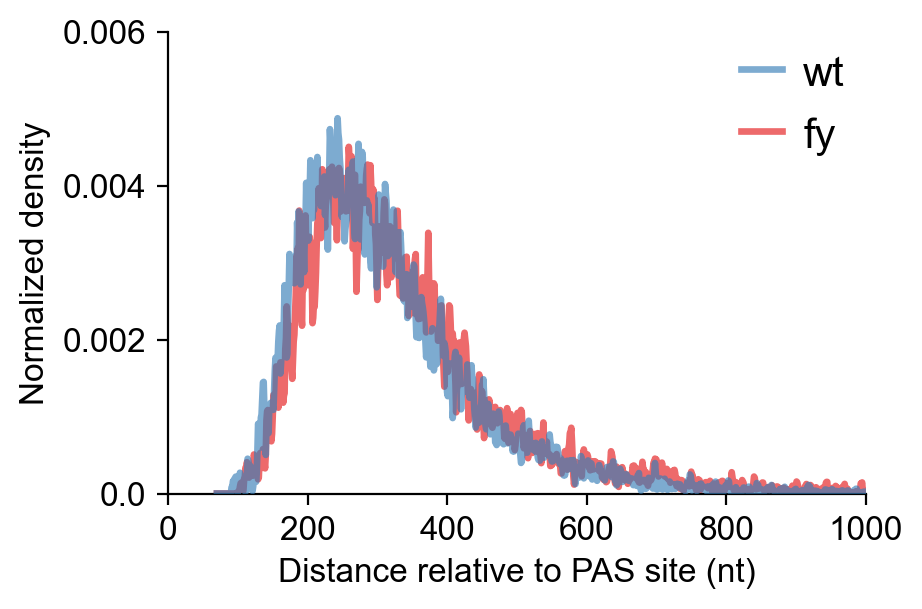

In [67]:
sample1 = ls_order[0]
sample2 = ls_order[1]
gcf = metaplot.draw_comp_PAS_3cl(eval(sample1 + "_cl")[0], 
                                 eval(sample1 + "_cl")[1], 
                                 eval(sample2 + "_cl")[0], 
                                 eval(sample2 + "_cl")[1], 
                                 sample1, sample2)